# Density Tree for N-dimensional data and labels
The code below implements a **density** tree for non-labelled data.

## Libraries
First, some libraries are loaded and global figure settings are made for exporting.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import os
from IPython.core.display import Image, display

# Custom Libraries
from density_tree.density_forest import *
from density_tree.density_tree_create import *
from density_tree.density_tree_traverse import *
from density_tree.create_data import *
from density_tree.helpers import *
from density_tree.plots import *

# Generate Data

First, let's generate some unlabelled data:


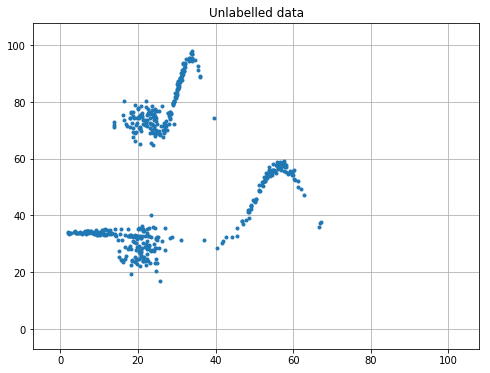

In [2]:
dimensions = 2
nclusters = 5
covariance = 10
npoints = 100
minRange = 10
maxRange = 100

dataset = create_data(nclusters, dimensions, covariance, npoints, minrange=minRange, maxrange=maxRange,
                      labelled=False, random_flip=True, nonlinearities=True)

if dimensions == 2:
    fig, ax = plt.subplots(1, 1)
    fig.set_size_inches(8,6)
    plot_data(dataset, "Unlabelled data", ax, labels=False)
    plt.savefig("figures/unlabelled-data.pdf", bbox_inches='tight', pad_inches=0)
    plt.show()

#### Create single Density Tree

In [3]:
import warnings
warnings.filterwarnings("ignore")
root = create_density_tree(dataset, dimensions=dimensions, clusters=nclusters)

In [4]:
def get_values_preorder(node, cut_dims, cut_vals):
    cut_dims.append(node.split_dimension)
    cut_vals.append(node.split_value)
    if node.left is not None:
        get_values_preorder(node.left, cut_dims, cut_vals)
    if node.right is not None:
        get_values_preorder(node.right, cut_dims, cut_vals)
    return cut_vals, cut_dims

cut_vals, cut_dims = get_values_preorder(root, [], [])
cut_vals = np.asarray(cut_vals).astype(float)
cut_dims = np.asarray(cut_dims).astype(int)

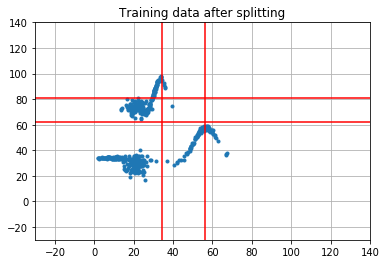

In [5]:
x_split = cut_vals[cut_dims == 0]
y_split = cut_vals[cut_dims == 1]

if dimensions == 2:
    fig, ax = plt.subplots(1, 1)
    plot_data(dataset, "Training data after splitting", ax, labels=False, lines_x=x_split, lines_y=y_split,
              minrange=minRange, maxrange=maxRange, covariance=covariance)

    %clear
    plt.show()

In [6]:
print(cut_dims, cut_vals)

[1 0 0 1] [ 61.86576149  34.2579225   56.26053125  80.87289246]


# Printing the Tree

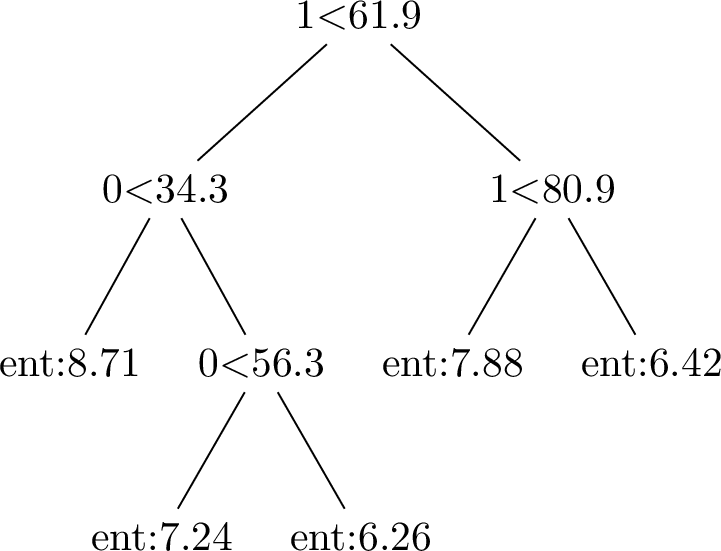

In [7]:
def tree_visualize(root):
    tree_string = ""
    tree_string = print_density_tree_latex(root, tree_string)
    
    os.system("cd figures; rm main.tex; more main_pt1.tex >> main.tex; echo '' >> main.tex;")
    os.system("cd figures; echo '" + tree_string + "' >> main.tex;  more main_pt2.tex >> main.tex;")
    os.system("cd figures; /Library/TeX/texbin/pdflatex main.tex; convert -density 300 -trim main.pdf -quality 100 main.png")
    display(Image('./figures/main.png', retina=True))
    
tree_visualize(root)

#### Showing all Clusters Covariances

In [8]:
covs, means = get_clusters(root, [], [])

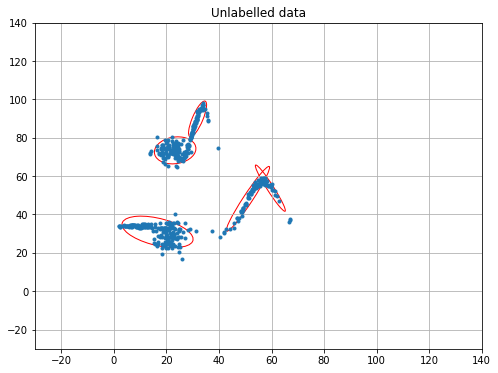

[1 0 0 1] [ 61.86576149  34.2579225   56.26053125  80.87289246]


In [9]:
if dimensions == 2:
    fig, ax = plt.subplots(1, 1)
    fig.set_size_inches(8,6)
    plot_data(dataset, "Unlabelled data", ax, labels=False, covs=covs, means=means,
              minrange = minRange, maxrange = maxRange, covariance=covariance)
    plt.savefig("figures/unlabelled-data-cov.pdf", bbox_inches='tight', pad_inches=0)
    plt.show()
    print(cut_dims, cut_vals)

#### Descend tree (predict "label")

In [10]:
# for all points 
probas = []
probas_other = []
for d in dataset:
    # descend tree
    d_mean, d_cov, d_pct = descend_density_tree(d,root)

    # probability for this point to be from this distribution
    probas.append(multivariate_normal.pdf(d, d_mean, d_cov)*d_pct)
    for i in range(5):
        probas_other.append(multivariate_normal.pdf(d, means[i], covs[i])*d_pct)
    
print("Probability to come from the leaf node cluster: %.5f%%" % np.mean(probas))
print("Probability to come from an arbitrary cluster: %.5f%%" % np.mean(probas_other))

Probability to come from the leaf node cluster: 0.00147%
Probability to come from an arbitrary cluster: 0.00030%


#### Density Forest

In [11]:
root_nodes = density_forest_create(dataset, dimensions, nclusters, 100, .3, -1)

[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    2.1s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:    5.4s finished


In [13]:
probas = density_forest_traverse(dataset, root_nodes)

100%|██████████| 500/500 [00:08<00:00, 57.07it/s] 


In [14]:
print(np.mean(probas))

0.00139946589172
